In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os



In [11]:
def show_image_fixed(img, title="", is_bgr=True, is_gray=False, zoom=1.0, step=25):
    height, width = img.shape[:2]
    figsize = (width * zoom / 50, height * zoom / 50)

    plt.figure(figsize=figsize)
    if is_gray:
        plt.imshow(img, cmap='gray')
    elif is_bgr:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)

    plt.title(title)
    plt.xticks(np.arange(0, width, step))
    plt.yticks(np.arange(0, height, max(height // 20, 1)))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

def plot_histogram_full_width(histogram, image_width, zoom=1.0, step=50):
    height = 600  # pixel, chỉ là chiều cao cho dễ nhìn
    figsize = (image_width * zoom / 50, height * zoom / 100)

    plt.figure(figsize=figsize)
    plt.plot(np.arange(len(histogram)), histogram, color='blue', linewidth=1.5)
    plt.title('Histogram theo chiều rộng ảnh', fontsize=14)
    plt.xlabel('Vị trí cột (pixel)', fontsize=12)
    plt.ylabel('Tổng pixel', fontsize=12)
    plt.xticks(np.arange(0, image_width, step))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [12]:
def pre_process(image):
    roi = image
    gray_image = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    blur_median = cv2.medianBlur(gray_image, 5)
    alpha = 2.25  # contrast > 1 → tăng contrast mạnh
    beta = -50     # không thay đổi độ sáng
    high_contrast = cv2.convertScaleAbs(blur_median, alpha=alpha, beta=beta)
    # inverted = 255 - high_contrast
    inverted = 255 - blur_median
    thresh_val, binary = cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # edges = cv2.Canny(inverted, threshold1=50, threshold2=150)

    # Hiển thị từng bước
    show_image_fixed(roi, "Step 1 - ROI")
    show_image_fixed(gray_image, "Step 2 - GRAY IMG")
    show_image_fixed(blur_median, "Step 3 - MEDIAN BLUR")
    # show_image_fixed(high_contrast, "Step 4 - HIGH CONTRAST")
    show_image_fixed(inverted, "Step 5 - INVERTED")
    show_image_fixed(binary, "Step 6 - THRESH HOLD")
    # show_image_fixed(edges, "Step 7 - EDGE DETECTION")

    # histogram = np.sum(edges, axis=0) 
    # plot_histogram_full_width(histogram, image.shape[1], zoom=1.2, step=50)

    return binary


In [13]:
def find_nearest_white_points(edge_image, x_ref, y_ref):
    y = y_ref-520 #Do đã crop ảnh nên trong ảnh mới Y sẽ có giá trị từ 0 - 199
    row_pixels = edge_image[y, :]  # Lấy toàn bộ dòng y cần detect
    
    # Tìm các vị trí x có giá trị 255 (trắng)
    white_x_positions = np.where(row_pixels == 255)[0]

    if len(white_x_positions) == 0:
        print("Không tìm thấy điểm trắng nào trên hàng này.")
        return 0, 1279

    # Tách điểm bên trái và bên phải x_ref
    left_points = [x for x in white_x_positions if x < x_ref] #tìm tất cả điểm trắng bên trái
    right_points = [x for x in white_x_positions if x > x_ref] #tìm tất cả điểm trắng bên phải

    # Lấy điểm gần nhất bên trái và bên phải
    x_left = max(left_points) if left_points else 0
    if len(left_points) > 10:
        for i in range(len(left_points)-1, 9, -1):
            if (left_points[i] - left_points[i-10] != 10):
                x_left = left_points[i-1]
            else:
                break

    x_right= min(right_points) if right_points else 1279
    if len(right_points) > 10:
        for i in range(len(right_points)-10):
            if (right_points[i+10] - right_points[i] != 10):
                x_right = right_points[i+1]
            else:
                break
    return x_left, x_right

In [14]:
#Tính toán góc và tính chính
def find_angle(edge_image,y_down, y_up, center, center_secondary):
    #tìm 4 điểm thuộc lane cần detect
    # x_left_1, x_left_2 là 2 điểm thuộc lane trái
    # x_right_1, x_right_2 là 2 điểm thuộc lane phải
    x_left_1, x_right_1 = find_nearest_white_points(edge_image, center, y_down)
    x_left_2, x_right_2 = find_nearest_white_points(edge_image, center, y_up)


    if ((x_left_1 == 0)|(x_left_2==0))&(x_right_1<x_right_2): #Nếu không nhìn thấy Lane bên trái và x_right_1 nhỏ hơn x_right_2 => cần detect lại
        x_left_1, x_right_1 = find_nearest_white_points(edge_image, center_secondary, y_down) 
        x_left_2, x_right_2 = find_nearest_white_points(edge_image, center_secondary, y_up)
    elif ((x_right_1 == 1279)|(x_right_2 == 1279))&(x_left_1 > x_left_2): #Nếu không nhìn thấy Lane bên phải và x_left_1 lớn hơn x_left_2 => cần detect lại
        x_left_1, x_right_1 = find_nearest_white_points(edge_image, center_secondary, y_down)
        x_left_2, x_right_2 = find_nearest_white_points(edge_image, center_secondary, y_up)
    
    #tìm điểm trung tâm
    x_center = (x_left_1 + x_right_1)//2 
    x_up = (x_left_2 + x_right_2)//2

    #tính toán góc
    tan = (x_center- x_up)/(y_down-y_up)
    angle = np.arctan(tan)*180/3.1415
    return angle, x_center, x_up, x_left_1, x_right_1, x_left_2, x_right_2

In [15]:
#Tìm 2 điểm có thể là điểm trung tâm
def find_center_road(image, thres_value):
    histogram = np.sum(image, axis=0)  

    plot_histogram_full_width(histogram, image.shape[1], zoom=1.2, step=50)

    current_length = 0  # Chiều dài của đoạn hiện tại
    count = 0

    max_length = 0  # Đoạn dài nhất
    start_index = 0  # Vị trí bắt đầu của đoạn dài nhất
    end_index = 0  # Vị trí kết thúc của đoạn dài nhất
    
    max_length_secondary = 0 # Đoạn dài thứ hai
    start_index_secondary = 0 # Vị trí bắt đầu của đoạn dài thứ hai
    end_index_secondary = 0 # Vị trí kết thúc của đoạn dài thứ hai

    for i in range(0, 1279):
        if (histogram[i] < thres_value):
            if current_length == 0: #Chiều dài của đoạn hiện tại bằng 0 có nghĩa là đang bắt đầu một đoạn mới
                start_index_tmp = i  # Lưu lại vị trí bắt đầu của đoạn mới
            current_length += 1 #Tăng biến chiều dài hiện tại
            count = 0 #Reset biến count
        else:
            if current_length > 0:
                count +=1 #Đếm số lần Fail
                if count == 5: 
                    if current_length > max_length: #Nếu chiều dài của đoạn hiện tại lớn hơn chiều dài đoạn max hiện tại

                        max_length_secondary = max_length #Đoạn max hiện tại sẽ trở thành đoạn dài thứ 2 No.2
                        start_index_secondary = start_index #Lưu lại vị trí bắt đầu của đoạn dài thứ 2 No.2
                        end_index_secondary = end_index  #Lưu lại vị trí kết thúc của đoạn dài thứ 2 No.2

                        max_length = current_length #Giá trị của đoạn dài nhất No.1 bằng chiều dài của đoạn hiện tại
                        start_index = start_index_tmp #Lưu lại vị trí bắt đầu của đoạn dài nhất No.1
                        end_index = i - 6  #Lưu lại vị trí kết thúc của đoạn dài nhất No.1; trừ cho 6 là do phải đếm số lần Fail

                    elif current_length > max_length_secondary:# Nếu chiều dài của đoạn hiện tại không lớn hơn chiều dài Max nhưng lại lớn hơn đoạn dài thứ 2 No.2
                        max_length_secondary = current_length #Giá trị của đoạn dài thứ 2No.2 bằng chiều dài của đoạn hiện tại
                        start_index_secondary = start_index_tmp #Lưu lại vị trí bắt đầu của đoạn dài thứ 2 No.2
                        end_index_secondary = i - 6  #Lưu lại vị trí kết thúc của đoạn dài thứ 2 No.2

                    current_length = 0 #Reset biến chiều dài của đoạn hiện tại
                    count = 0 #Reset lại biến đếm

    # Kiểm tra nếu đoạn cuối cùng là đoạn dài nhất
    # Do ở đoạn code ở phía trên nếu đoạn cuối cùng kéo dài tới hết bức ảnh hay giá trị X = 1279 thì sẽ bỏ sót việc kiểm tra đoạn cuối cùng
    if current_length > max_length:
        max_length_secondary = max_length
        start_index_secondary = start_index
        end_index_secondary = end_index 

        max_length = current_length
        start_index = start_index_tmp
        end_index = len(histogram) - 1

    # Kiểm tra nếu đoạn cuối cùng là đoạn dài thứ 2 No.2
    elif current_length > max_length_secondary:
        max_length_secondary = current_length
        start_index_secondary = start_index_tmp
        end_index_secondary = len(histogram) - 1 

    #Tính toán giá trị các điểm trung tâm dựa theo các đoạn vừa tìm được
    center = (start_index + end_index)//2 #Điểm trung tâm dựa theo đoạn dài nhất No.1
    center_secondary = (start_index_secondary+end_index_secondary)//2 #Điểm trung tâm dựa theo đoạn dài thứ 2 No.2
    return center, center_secondary, start_index, end_index

In [16]:
def detect_in_cross_road(image, left_base, right_base):
    msk = image.copy()
    w_box = 40
    h_box = 15
    y = 0
    size = 480//h_box
    x_left = [0] * size
    x_right = [0] * size 
    found_contour_left = [False]* size
    found_contour_right = [False]* size
    count = 0
    while y < image.shape[0]:
        # Left side
        best_cx = 0
        min_diff = float('inf')
        img = image[y:y+h_box, left_base-w_box:left_base+w_box]
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 50:  # chỉ giữ contour có diện tích > 100 pixel
                found_contour_left[count]=True
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    diff = abs(cx - w_box)
                    if diff < min_diff:
                        best_cx = cx
                        min_diff = diff
        if best_cx != 0:
            left_base = left_base - w_box + best_cx
            x_left[count] = left_base
        else:
            x_left[count] = left_base
        # Right side
        best_cx = 0
        min_diff = float('inf')
        img = image[y:y+h_box, right_base-w_box:right_base+w_box]
        contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 50:  # chỉ giữ contour có diện tích > 100 pixel
                found_contour_right[count]=True
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    diff = abs(cx - w_box)
                if diff < min_diff:
                    best_cx = cx
                    min_diff = diff
        if best_cx != 0: 
            right_base = right_base - w_box + best_cx
            x_right[count] = right_base 
        else:
            x_right[count] = right_base
        cv2.rectangle(msk, (left_base - w_box, y), (left_base + w_box, y + h_box), (255, 255, 255), 2)
        cv2.rectangle(msk, (right_base - w_box, y), (right_base + w_box, y + h_box), (255, 255, 255), 2)
        y += h_box
        count+=1
        
    contour_left = 0
    contour_right = 0
    finish_left = False
    finish_right = False
    pos_left = 0
    pos_right = 0
    for i in range(size):
        #left side
        if not finish_left:
            if found_contour_left[i]:
                contour_left = 0
            elif not found_contour_left[i]:
                contour_left+=1
            if contour_left == 5 or i == (size-1):
                x1_left_contour = x_left[i-contour_left]
                x2_left_contour = x_left[i-contour_left-1]
                pos_left = h_box*(i-contour_left+1)
                finish_left = True
        #right side
        if not finish_right:
            if found_contour_right[i]:
                contour_right= 0
            elif not found_contour_right[i]:
                contour_right+=1
            if contour_right == 5 or i == (size-1):
                x1_right_contour = x_right[i-contour_right]
                x2_right_contour = x_right[i-contour_right-1]
                pos_right = h_box*(i-contour_right+1)
                finish_right = True

    slope_left = (x1_left_contour - x2_left_contour)/h_box
    slope_right = (x1_right_contour - x2_right_contour)/h_box
    x_left_1 = max(x1_left_contour + slope_left * (480 - pos_left), 0)    
    x_left_2 = max(x1_left_contour + slope_left*(280 - pos_left), 0)
    x_right_1 = min(x1_right_contour + slope_right*(480 - pos_right), 1279)
    x_right_2 = min(x1_right_contour + slope_right*(280 - pos_right), 1279)

    x_center = (x_left_1 + x_right_1)//2
    x_center_up = (x_left_2+x_right_2)//2
    tan = (x_center- x_center_up)/(200)
    angle = np.arctan(tan)*180/3.1415

    #Draw line
    cv2.line(msk, (0, 280), (1279,280), color=(0, 0, 0), thickness=4)
    cv2.line(msk, (0, 280), (1279,280), color=(255, 255, 255), thickness=2)
    cv2.line(msk, (int(x_left_1), size*h_box), (int(x1_left_contour),pos_left), color=(0, 0, 0), thickness=4)
    cv2.line(msk, (int(x_left_1), size*h_box), (int(x1_left_contour),pos_left), color=(255, 255, 255), thickness=2)
    cv2.line(msk, (int(x_right_1), size*h_box), (int(x1_right_contour),pos_right), color=(0, 0, 0), thickness=4)
    cv2.line(msk, (int(x_right_1), size*h_box), (int(x1_right_contour),pos_right), color=(255, 255, 255), thickness=2)
    cv2.line(msk, (int(x_center), size*h_box), (int(x_center_up),280), color=(0, 0, 0), thickness=4)
    cv2.line(msk, (int(x_center), size*h_box), (int(x_center_up),280), color=(255, 255, 255), thickness=2)
    show_image_fixed(msk, "Step 7 - original")
    # cv2.imshow("original", msk)
    # cv2.imshow("original", msk)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    return angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2

In [17]:
def cv_process(img, process_crossroads):
    show_image_fixed(img, "Step 0 - RAW IMAGE")
    if not process_crossroads:
        roi = img[520:720, :]
        pre_process_img = pre_process(roi) 
        center, center_secondary, start_index, end_index = find_center_road(pre_process_img, 300)
        angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2= find_angle(pre_process_img, 719, 520, center, center_secondary)

    else:
        roi = img[240:720, :]
        pre_process_img = pre_process(roi)
        center, center_secondary, start_index, end_index = find_center_road(pre_process_img, 3000)
        angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2= detect_in_cross_road(pre_process_img, start_index, end_index)
 
    return angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2
    # return 0, 0, 0, 0, 0, 0, 0

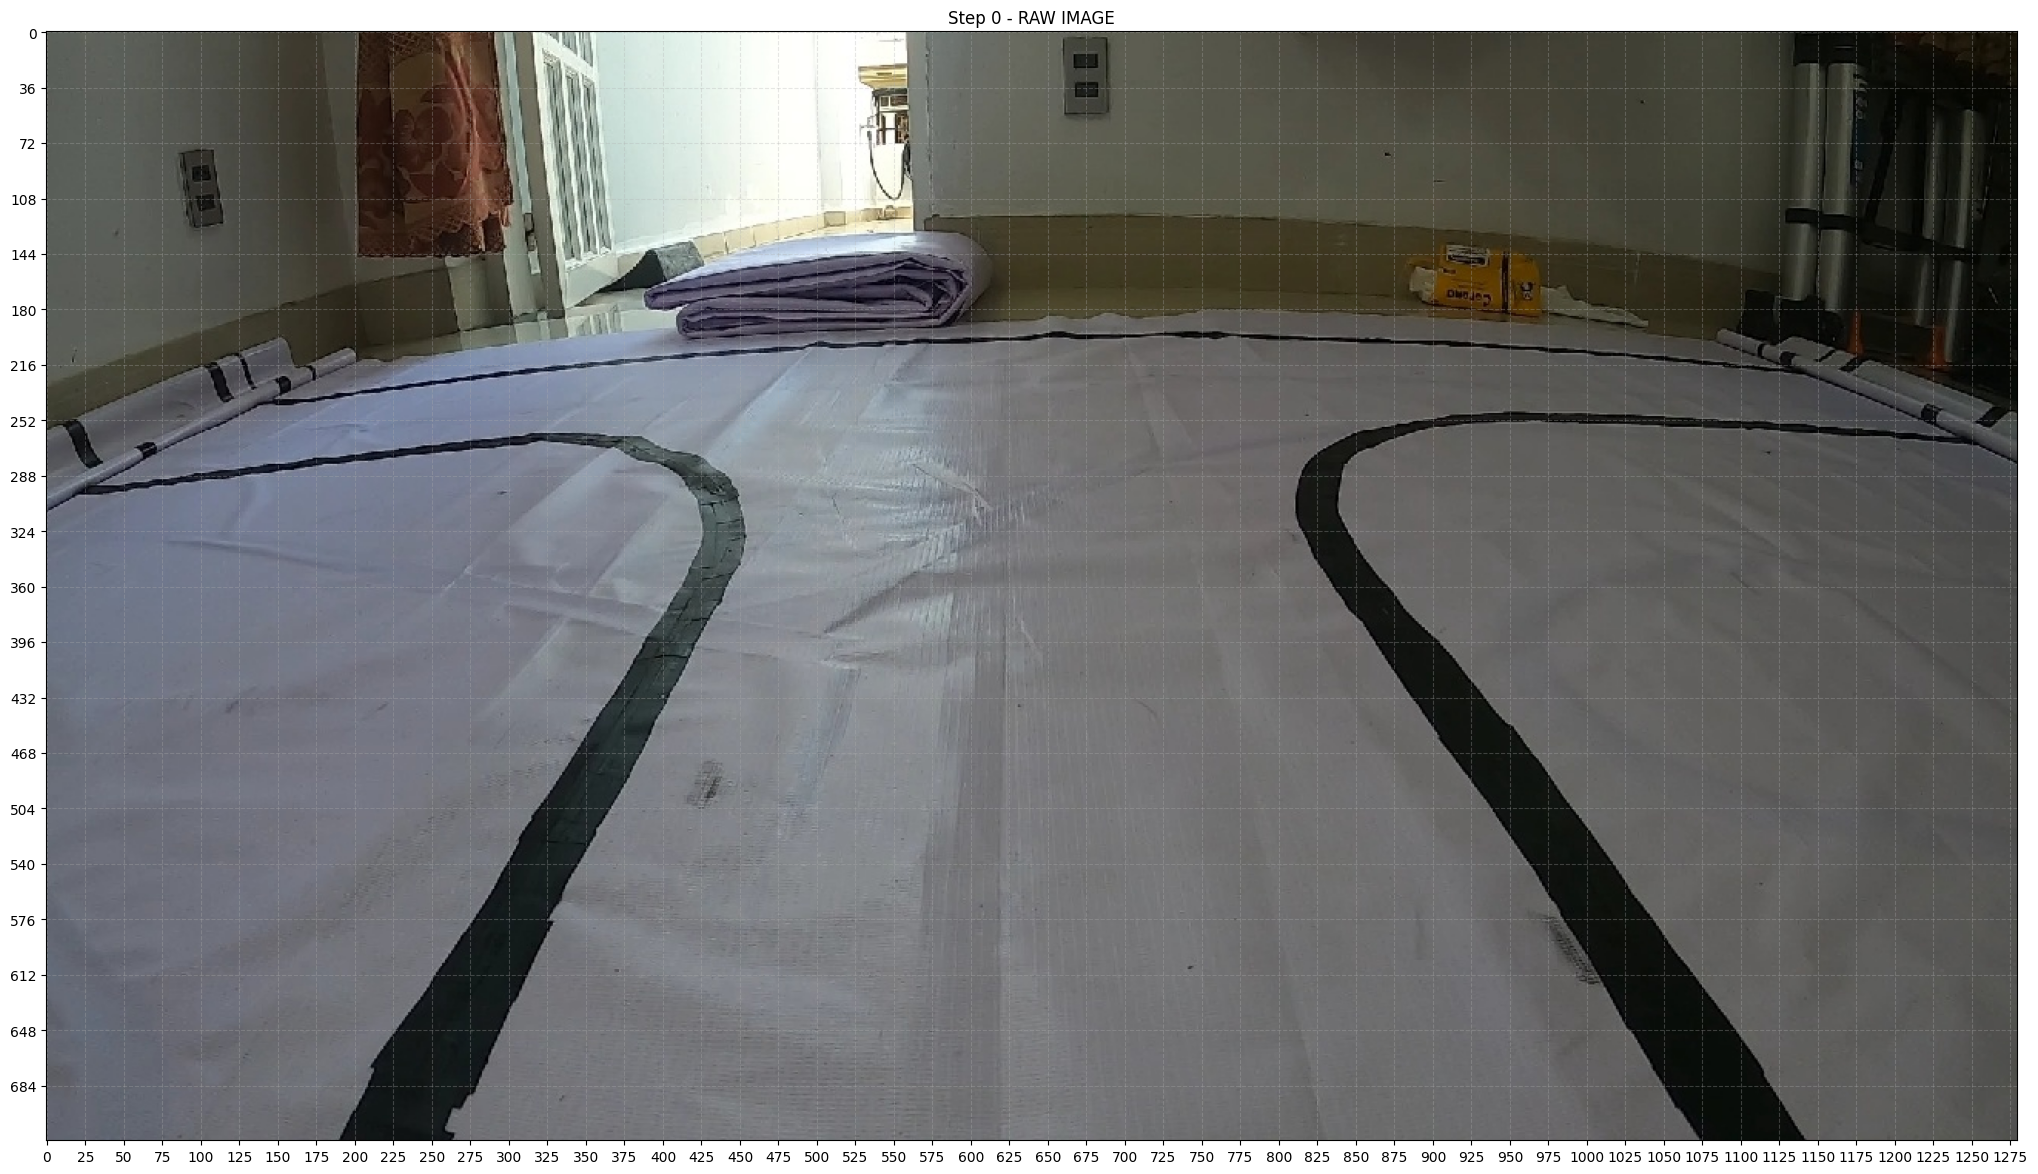

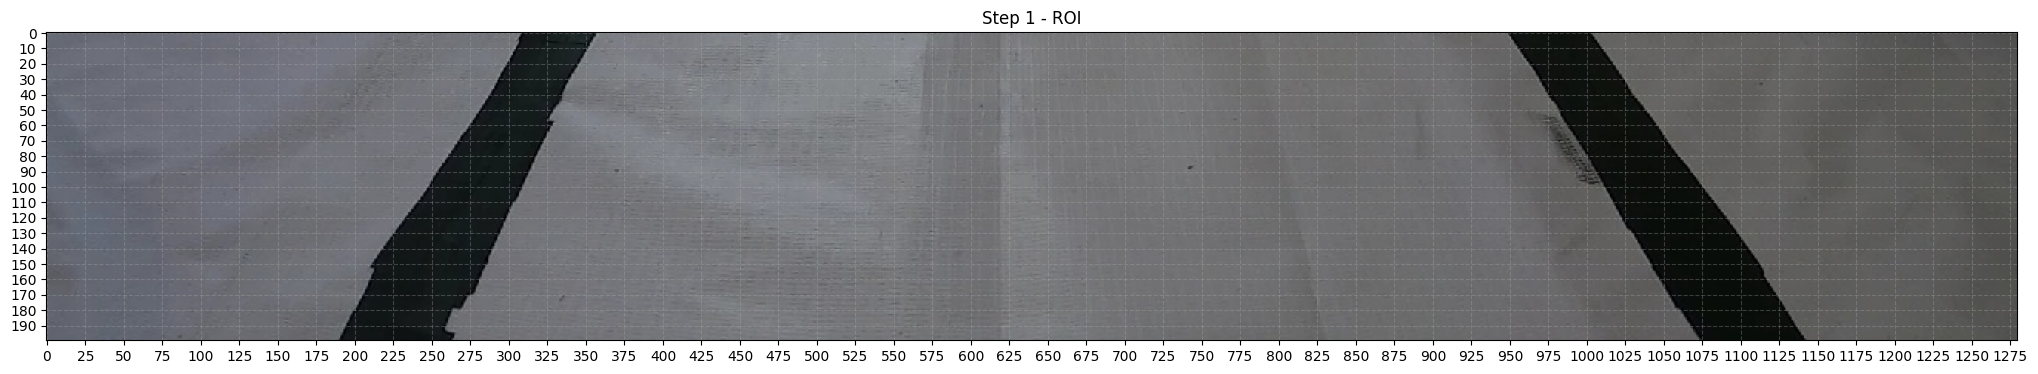

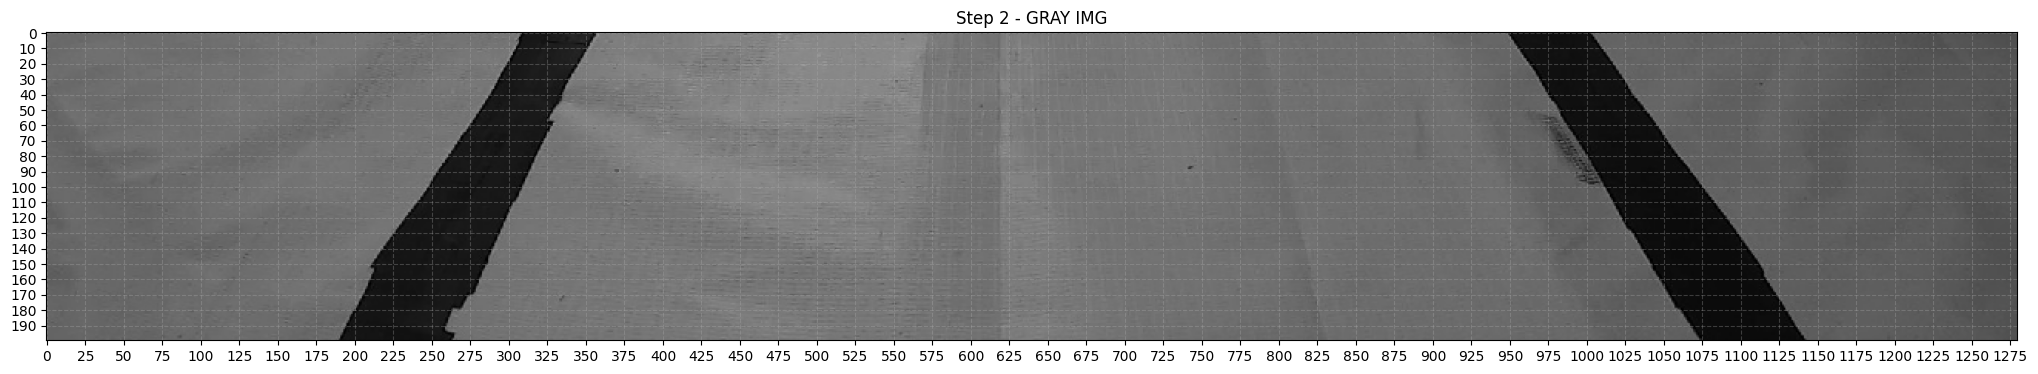

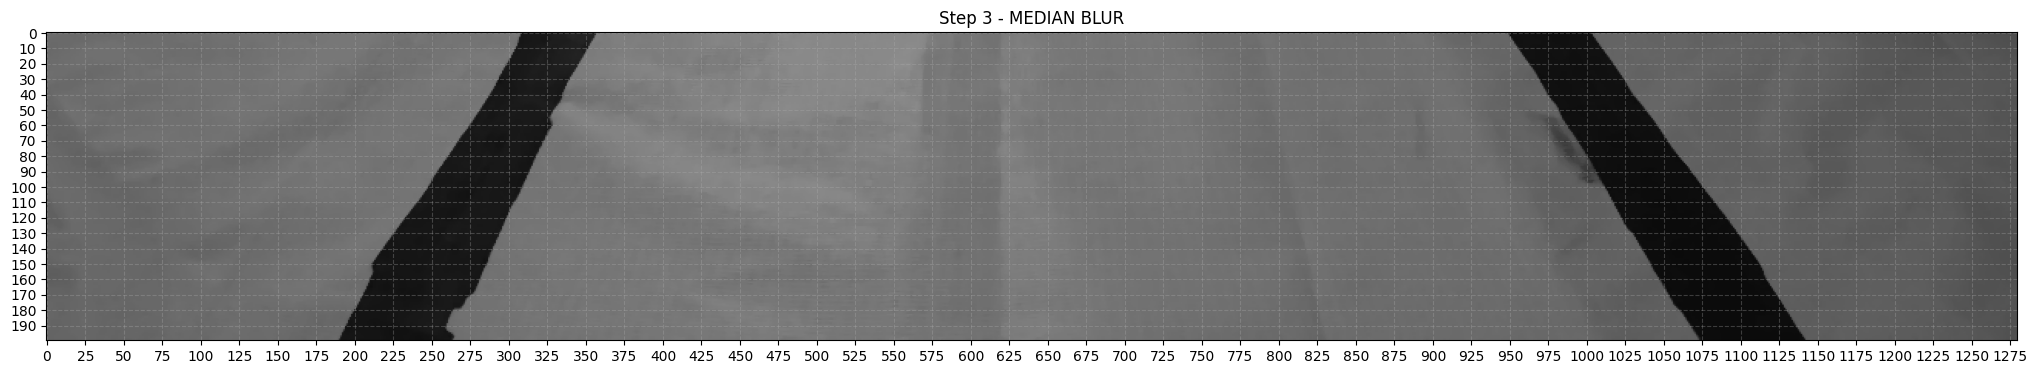

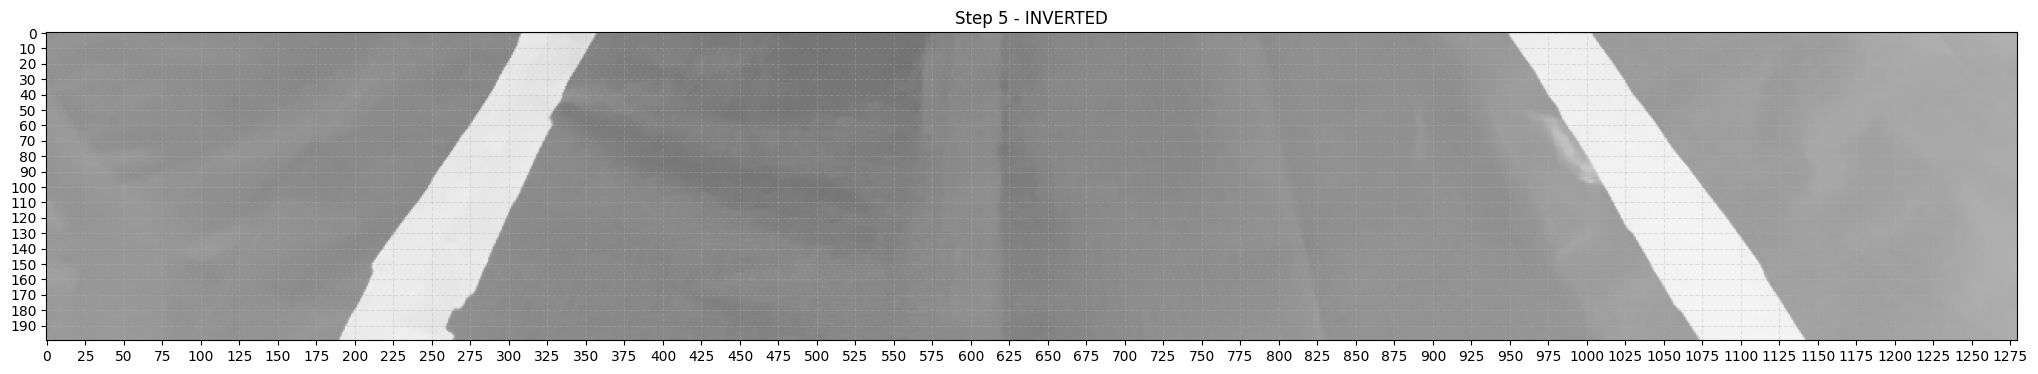

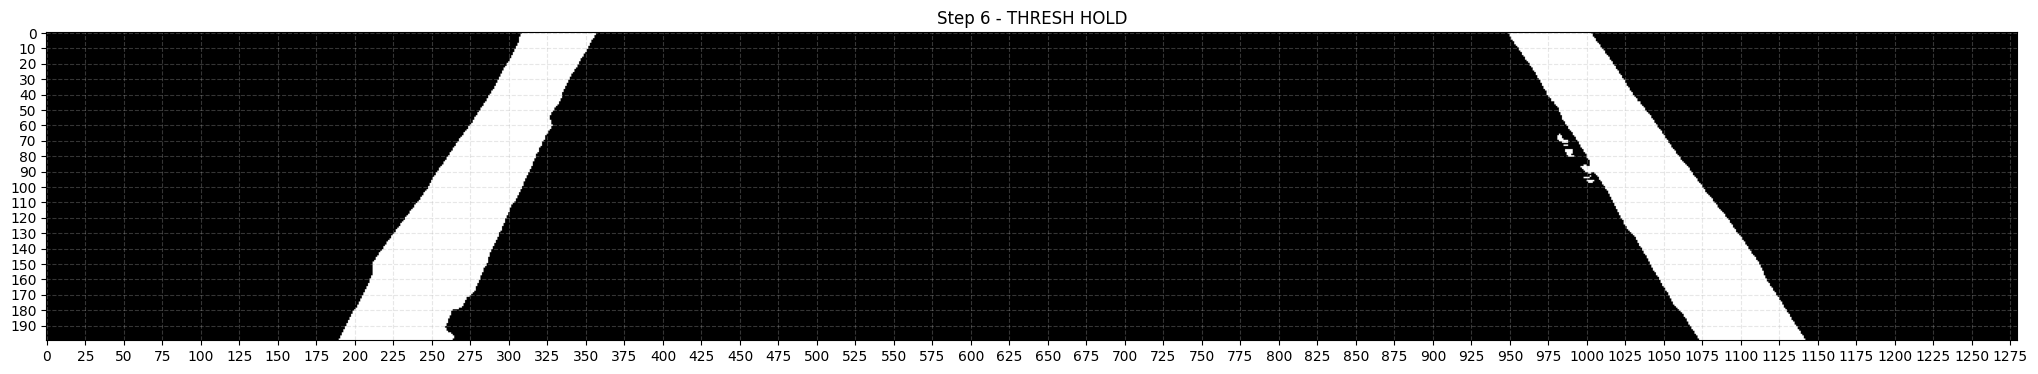

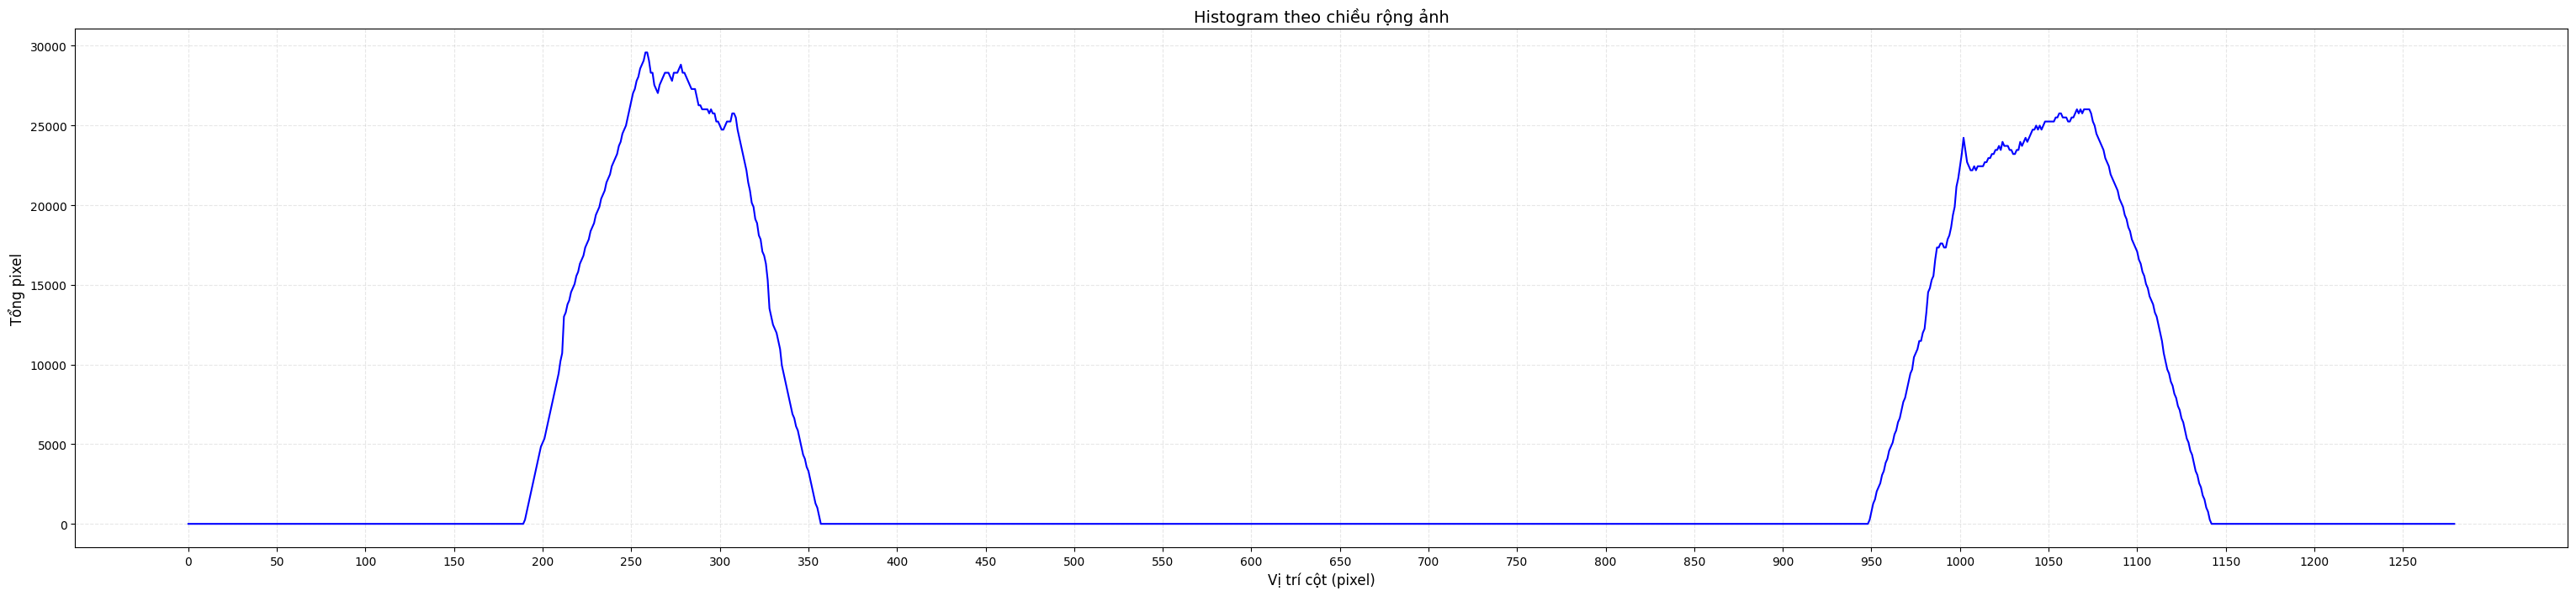

Angle: 4.596943105300496
Center: 668
Center_up: 652
Left1: 263
Right1: 1073
Left2: 356
Right2: 949


In [18]:
if __name__ == "__main__":

    image = cv2.imread("r_frame_054_base.jpg")
    # image = cv2.imread("r_frame_058.png")
    angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2 = cv_process(image, False)
    print("Angle: {}\nCenter: {}\nCenter_up: {}\nLeft1: {}\nRight1: {}\nLeft2: {}\nRight2: {}".format(
    angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2))

    # image = cv2.imread("r_frame_023 correct phi).jpg")
    # angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2 = cv_process(image)
    # print("Angle: {}\nCenter: {}\nCenter_up: {}\nLeft1: {}\nRight1: {}\nLeft2: {}\nRight2: {}".format(
    # angle, x_center, x_center_up, x_left_1, x_right_1, x_left_2, x_right_2))

    # for i in range(8, 17):  # từ 8 đến 16
    #     filename = "r_frame_{:03d}.jpg".format(i)
    #     image = cv2.imread(filename)
        
    #     if image is None:
    #         print("❌ Không thể đọc ảnh: {}".format(filename))
    #         continue

    #     angle, x_center, x_left_1, x_right_1, x_left_2, x_right_2 = cv_process(image)
        
    #     print("===== {} =====".format(filename))
    #     print("Angle: {}\nCenter: {}\nLeft1: {}\nRight1: {}\nLeft2: {}\nRight2: {}\n".format(
    #         angle, x_center, x_left_1, x_right_1, x_left_2, x_right_2))